# Smoothed Thermostat

(this is the same notebook as Termostat, except that here the input script is not manually smoothed, instead the smoothing happens automatically)

Example taken from: Chaudhuri, S., & Solar-Lezama, A. (2010, June). Smooth interpretation. In Proceedings of the 31st ACM SIGPLAN Conference on Programming Language Design and Implementation (pp. 279-291).

```
tOff = ?, tOn = ?

repeat {
    temp = readTemp()
    if isOn() and temp > tOff {
        isOn = False
    }
    else if not isOn() and temp < tOn {
        isOn = True
    }
}
```

Temperature evolves according to:
$$ \frac{d \textit{temp}}{dt} = \begin{cases} -k \cdot \textit{temp} + h \, (+ \text{gauss}(0, \epsilon)) & \text{if isON} \\
                                              -k \cdot \textit{temp} \, (+ \text{gauss}(0, \epsilon)) & \text{is not isOn}  \end{cases} $$

I generate temperature trajectories for $tOn =, tOff=, k=, h=, \epsilon=$ and try to synthesize $tOn, tOff$ using as loss the log-likelihood over trajectories.

In [1]:
from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *
from libSOGA import *
from time import time

torch.set_default_dtype(torch.float64)

### Original model

In [4]:
def orig_model(T=10, init_T=17., tOn=18, tOff=20, k=0.01, h=0.5, eps=0.5):
    traj = torch.zeros(T)
    isOn = False
    traj[0] = init_T
    noise = distributions.Normal(torch.tensor(0.), torch.tensor(eps))
    
    for i in range(1,T):
        
        #update temperature
        if isOn:
            traj[i] = traj[i-1] -k*traj[i-1] + h + noise.rsample() 
        else:
            traj[i] = traj[i-1] -k*traj[i-1] + noise.rsample() 

        # update thermostat state
        if isOn and traj[i] > tOff:
            isOn = False
        elif not isOn and traj[i] < tOn:
            isOn = True
            
    return traj        

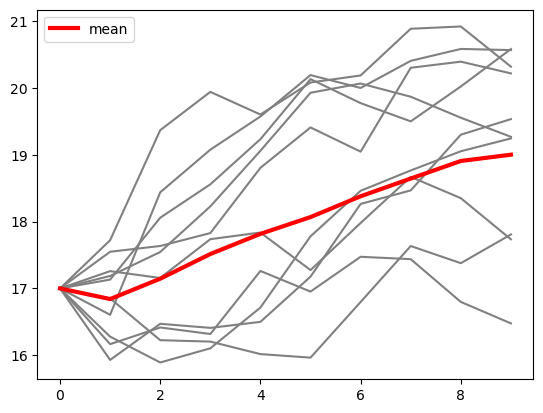

In [5]:
# generation of a set of trajectories

import matplotlib.pyplot as plt

traj_set = []
for _ in range(100):
    traj_set.append(orig_model())
traj_set = torch.vstack(traj_set)

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), traj_set[i], color='grey')

plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='red', label='mean')
plt.legend()

### VI Optimization

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
import torch
import torch.nn.functional as F

# Pyro model
def pyro_model(observed_traj, T=10, init_T=17., k=0.01, h=0.5, eps=0.5):
    # Priors for tOn and tOff
    tOn = pyro.sample("tOn", dist.Normal(18.0, 2.0))  # Prior mean=18, std=2
    tOff = pyro.sample("tOff", dist.Normal(20.0, 2.0))  # Prior mean=20, std=2

    traj = torch.zeros(T)
    traj[0] = init_T
    isOn = False
    noise = dist.Normal(0.0, eps)

    for i in range(1, T):
        # Update temperature
        if isOn:
            traj[i] = traj[i - 1] - k * traj[i - 1] + h + noise.sample()
        else:
            traj[i] = traj[i - 1] - k * traj[i - 1] + noise.sample()

        # Update thermostat state
        if isOn and traj[i] > tOff:
            isOn = False
        elif not isOn and traj[i] < tOn:
            isOn = True

    # Condition on observed trajectories
    #print(traj.unsqueeze(1).expand(100).shape)
    #print(observed_traj.shape)
    # Use pyro.plate to handle batch dimensions
    with pyro.plate("data", N):
        pyro.sample("obs", dist.Normal(z3.squeeze(-1), sigma_obs).to_event(1), obs=Y.squeeze(-1))
    pyro.sample("obs", dist.Normal(traj, eps).to_event(1), obs=observed_traj)

# Guide (variational distribution)
def pyro_guide(observed_traj, T=10, init_T=17., k=0.01, h=0.5, eps=0.5):
    # Variational parameters for tOn and tOff
    tOn_loc = pyro.param("tOn_loc", torch.tensor(18.0))
    tOn_scale = pyro.param("tOn_scale", torch.tensor(1.0), constraint=dist.constraints.positive)
    tOff_loc = pyro.param("tOff_loc", torch.tensor(20.0))
    tOff_scale = pyro.param("tOff_scale", torch.tensor(1.0), constraint=dist.constraints.positive)

    # Sample tOn and tOff from variational distributions
    pyro.sample("tOn", dist.Normal(tOn_loc, tOn_scale))
    pyro.sample("tOff", dist.Normal(tOff_loc, tOff_scale))

# Observed trajectories (example)
T = 10
observed_traj = torch.stack([torch.tensor(orig_model()) for _ in range(100)])

# SVI setup
pyro.clear_param_store()
optimizer = pyro.optim.Adam({"lr": 0.01})
svi = SVI(pyro_model, pyro_guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 1000
for step in range(num_steps):
    loss = svi.step(observed_traj)
    if step % 100 == 0:
        print(f"Step {step} - Loss: {loss}")

# Retrieve optimized parameters
tOn_opt = pyro.param("tOn_loc").item()
tOff_opt = pyro.param("tOff_loc").item()
print(f"Optimized tOn: {tOn_opt}, tOff: {tOff_opt}")

C:\Users\birik\AppData\Local\Temp\ipykernel_21992\3147368476.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  observed_traj = torch.stack([torch.tensor(orig_model()) for _ in range(100)])


ValueError: at site "obs", invalid log_prob shape
  Expected [], actual [100]
  Try one of the following fixes:
  - enclose the batched tensor in a with pyro.plate(...): context
  - .to_event(...) the distribution being sampled
  - .permute() data dimensions

### SOGA program

In [20]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/ThermostatNoSmooth.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

pars = {'tOff':22., 'tOn':16.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

output_dist = start_SOGA(cfg, params_dict)

In [22]:
output_dist.gm.n_comp()

47

In [7]:
output_dist.gm.mean()

tensor([17.0000, 16.8300, 16.6859, 16.6115, 16.6038, 16.6498, 16.7380, 16.8599,
        17.0091, 17.1805, 17.5736, 17.5736,  0.5625, 17.5736],
       grad_fn=<SumBackward1>)

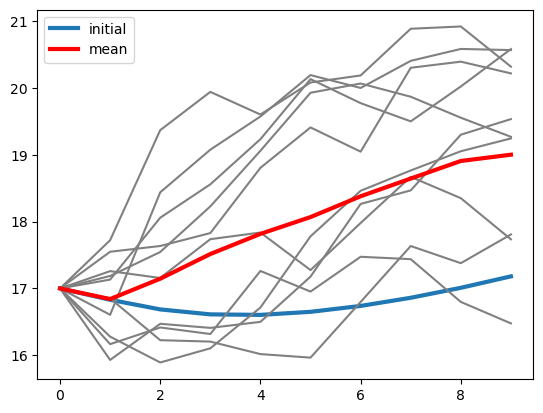

In [8]:
import matplotlib.pyplot as plt

y_init = output_dist.gm.mean()[:10].detach()
plt.plot(range(10), y_init, lw=3, label='initial')

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), traj_set[i], color='grey')

plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='red', label='mean')
plt.legend()

In [9]:
def neg_log_likelihood(traj_set, dist):
    idx = [1,2,3,4,5,6,7,8,9]
    log_likelihood = torch.log(dist.gm.marg_pdf(traj_set[:, idx].unsqueeze(0), idx))
    return - torch.sum(log_likelihood)

def L2_distance(traj_set, dist):
    idx = [1,2,3,4,5,6,7,8,9]
    output_traj = dist.gm.mean()[idx]
    return torch.sum(torch.pow(traj_set[:, idx] - output_traj,2))

neg_log_likelihood(traj_set, output_dist)
        

tensor(1359.2527, grad_fn=<NegBackward0>)

In [10]:
# Define the optimizer with init_mean as the parameter

#torch.autograd.set_detect_anomaly(True)
pars = {'tOff':22., 'tOn':16.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.05)

total_start = time()

for i in range(100):

    optimizer.zero_grad()  # Reset gradients
    
    # loss
    current_dist = start_SOGA(cfg, params_dict)

    loss = neg_log_likelihood(traj_set, current_dist)

    # Backpropagate
    loss.backward()
    
    optimizer.step()

    
    # Print progress
    if i % 10 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item()) + ' '
        out = out + f" loss: {loss.item()}"
        print(out)

total_end = time()

print('Optimization performed in ', round(total_end-total_start, 3))


tOff: 22.049999999760427 tOn: 16.049999999999063  loss: 1359.2526981079818
tOff: 22.557925580695308 tOn: 16.55656284986422  loss: 997.0934448441051
tOff: 23.029189755838367 tOn: 17.02035304255668  loss: 771.9244424322602
tOff: 23.321840534422105 tOn: 17.333746130154932  loss: 719.8987238230088
tOff: 23.414808556548167 tOn: 17.522430304184137  loss: 704.7385907210671
tOff: 23.38087946288443 tOn: 17.63956599718658  loss: 698.790918162224
tOff: 23.284802272061633 tOn: 17.714585430342076  loss: 696.4282791735461
tOff: 23.17430373324319 tOn: 17.76261374972241  loss: 695.4975854200625
tOff: 23.086509349531504 tOn: 17.79375817538633  loss: 695.1144994749699
tOff: 23.041750681689905 tOn: 17.814800630347584  loss: 694.9425627349165
Optimization performed in  108.413


In [11]:
params_dict

{'tOff': tensor(23.0349, requires_grad=True),
 'tOn': tensor(17.8286, requires_grad=True)}

In [12]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/ThermostatNoSmooth.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict)

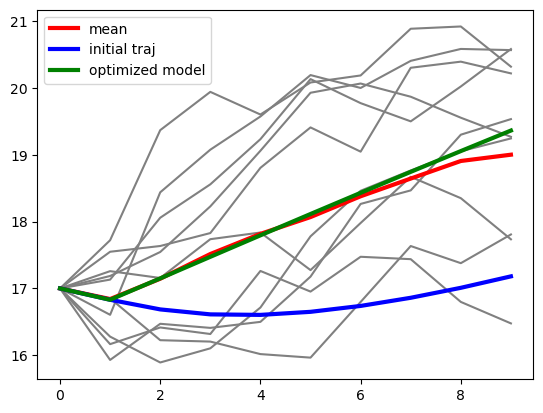

In [13]:
import matplotlib.pyplot as plt

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), traj_set[i], color='grey')

plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='red', label='mean')

plt.plot(range(10), y_init, lw=3, color='blue', label='initial traj')

plt.plot(range(10), output_dist.gm.mean()[:10].detach(), lw=3, color='green', label='optimized model')

plt.legend()